# Australian Rainfall

## Get the Data

The dataset used in this notebook can be found on Kaggle at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package. It contains "about 10 years of daily weather observations from many locations across Australia". 

Our objective is to derive a model that predicts if it will or will not rain the next day, given weather observations for a given location on a given day. 

The dataset contains observations for 23 variables. For each instance, the location and date are given, along with 19 weather metrics. These 19 metrics are mostly continuous, for example minimum and maximum temperature (measured in Celsius) or sky coverage (measured in eights (so a low precision scale of observation)), and three "cyclic" variables in the case of wind speed direction at 9AM and 3PM respectively and the direction of the strongest wind-gust (encoded as strings in this raw dataset). As well of these weather metrics, there are two binary variables indicating if it rained that day and if it rained the next day. "RainTomorrow" will act as our response variable (i.e. the associated "label" of each instance).

We begin by importing some key packages and loading our weather data into a pandas dataframe:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aus_weather_df = pd.read_csv('weatherAUS.csv') #Load the Australian Weather Data (will be dependent upon .csv location)
aus_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

We notice right away that the number of missing values (i.e. null values) varies wildly between features, and we will revisit this in the "Preparing the Data" section.

Let us also check how attributes of dtype "Object" are encoded:

In [3]:
aus_weather_df.select_dtypes('object')

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No
2,2008-12-03,Albury,WSW,W,WSW,No,No
3,2008-12-04,Albury,NE,SE,E,No,No
4,2008-12-05,Albury,W,ENE,NW,No,No
...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,E,SE,ENE,No,No
145456,2017-06-22,Uluru,NNW,SE,N,No,No
145457,2017-06-23,Uluru,N,SE,WNW,No,No
145458,2017-06-24,Uluru,SE,SSE,N,No,No


Lets check the type of the first entry in each of these columns (from the above we know it is non-null).

In [4]:
object_dtype_columns = aus_weather_df.select_dtypes('object').columns.values
for col in object_dtype_columns:
    print(type(aus_weather_df[col][0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


We see that that all these values are strings (which we could have infered by the data being from a .csv file).

For now, "string" is a suitable type for most of these values at this, but we will revisit this in the "Preparation of Data for Machine Learning" section.

However, let us convert the data in our "Date" column to "datatime" format for the convenient computational properties of encoding dates in this way (in pandas the values in the column will have python type "pandas.Timestamp", which is designed to mimic the "datetime.datetime" class).

In [5]:
aus_weather_df['Date'] = pd.to_datetime(aus_weather_df['Date'])

### Getting Geographic Data
Usually with a Kaggle dataset, getting the data happens in a single step. That is you simply get the .csv file and you're done. However, since it is often necessary to assemple a dataset from various sources in most machine learning projects in practical settings, I decided to expand this dataset slightly. 

In this dataset locations are given as a single string identifying a weather station in Australia by its name. Since weather will naturally be influenced by geographic location, it could be beneficial to include the latitude and longitude of the location for which each observation was made in our model. This puts location onto a geographic scale which could help our model (in combination with the catagorical observations of location).

I searched online for geagraphic data on Australian cities and found a "free to use" "Australian Cities" database which can be downloaded at https://simplemaps.com/data/au-cities.

It gives the names, latitudes, longitudes, and other attributes, for 1035 Australian cities. 

In [6]:
aus_geo_data_df = pd.read_csv('au.csv') #Load geographic for australia data (after downloading)
aus_geo_data_df['lat'][0]

-33.865

We would like a unique latitude and longitude for each city-location in our Australian weather data. Therefore we should inspect this Australian cities dataset to see if there are any missing values or surprises.

In [7]:
aus_geo_data_df.isnull().sum(axis = 0) #Count the number of null values for each column

city                    0
lat                     0
lng                     0
country                 0
iso2                    0
admin_name              0
capital              1026
population              0
population_proper       0
dtype: int64

We are only interested in latitude and longitude, so there are no missing values in the data of interest.

We now check for duplicate rows:

In [8]:
aus_geo_data_df.duplicated().sum()

0

Next we check for multiple occurences of cities with the same name, as we need a unique latitude and longitude value for each city in our Australian weather data.

In [9]:
aus_geo_data_df['city'].value_counts()

Longford        2
Gin Gin         2
Mount Barker    2
Emerald         2
Maryborough     2
               ..
Geelong         1
Forster         1
Stratford       1
Grenfell        1
Mossman         1
Name: city, Length: 1026, dtype: int64

We find that some cities appear twice in the database.
Inspecting the latitude and longitude values of "Richmond" specifically:

In [10]:
aus_geo_data_df[aus_geo_data_df['city'] == 'Richmond']

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
253,Richmond,-33.5983,150.7511,Australia,AU,New South Wales,NaN,5482,5482
793,Richmond,-42.7336,147.4394,Australia,AU,Tasmania,NaN,1464,1464


We see that there are two cities at different locations named "Richmond". 

We now chack which cities in this australian cities dataset correspond to locations in our australian weather dataset, and we then check if any of these cities correspond to multiple locations (i.e. there are multiple cities in Australia that share this name).

In [11]:
weather_locations_s = pd.Series(aus_weather_df['Location'].unique()) #Series of unique locations in weather data
city_in_weather_data = aus_geo_data_df['city'].isin(weather_locations_s)
cities_in_weather_data = aus_geo_data_df['city'][city_in_weather_data] #Cities in both weather data and Australian cities data
cities_in_weather_data.value_counts().head()

Richmond     2
Perth        2
Newcastle    1
Sale         1
Cobar        1
Name: city, dtype: int64

In [12]:
print(cities_in_weather_data.unique().size)
print(weather_locations_s.size)

26
49


We find that there is weather data for "Perth" and "Richmond" and that these two cities each correspond to two locations. 

We also find that Cities account for 26 out of 49 locations in our australian weather data.

At this point we would need to contact the provider of the australian weather data to find out which "Perth" and which "Richmond" their weather observations refer to. Since this is an exercise, we imagine that the cities of interest correspond to the first first occurence of each city in the Australian cities data. 

We use a "group-by" to transform the cities data in this way.

In [13]:
aus_geo_data_df = aus_geo_data_df.groupby('city', as_index = False).first()
aus_geo_data_df['city'].value_counts() #The value counts verify that there is now a unique location for each city

Ceduna          1
Lara            1
Bli Bli         1
Douglas Park    1
Robinvale       1
               ..
Avenel          1
Wauchope        1
Tailem Bend     1
Bomaderry       1
Rasmussen       1
Name: city, Length: 1026, dtype: int64

We now use the `merge` method to join our our australian weather data with our data on australian city locations, by joining along the 'Location' and 'city' columns for the respective datasets.

In [14]:
city_to_coord_df = aus_geo_data_df[['city', 'lat', 'lng']] #Dataframe containing only city name and latitude/longitude

Now we turn our attention to locations that are not cities (according to the names given in the previos dataset at least).

In [15]:
non_city = ~weather_locations_s.isin(cities_in_weather_data)
non_city_locations = weather_locations_s[non_city]
non_city_locations.size

23

I fill in coordinates for the remaining locations manualy with the help of Google search.

Note: This could have been automated, but would still have required additional information to be researched and provided as existing packages rely upon a full address to derive coordinates. Since there are only 23 locations to lookup it is not too time consuming to enter them manually. Also, as we would expect new data to belong to one of the existing locations it does not seem necessary to automate this process, as we do not expect to have to expand upon this in the future (although it is always best to seek to automate efficiently). And finally, since the purpose of this project is to practice machine learning and the associated considerations it seemes unnecessary to dedicate substantial time to learning new packages for this purpose. If there were hundreds of locations then automating this process would certainly be necessary (if the locations gave enough information to effectively do so).

In [16]:
location_coord_df = pd.DataFrame(np.array([['BadgerysCreek', - 33.8829, 150.7609], ['CoffsHarbour', - 30.2986, 153.1094],
 ['NorahHead',- 33.2833, 151.5667], ['NorfolkIsland',- 29.0408, 167.9547],  
 ['SydneyAirport',- 33.9399, 151.1753], ['WaggaWagga',- 35.1082, 147.3598],
 ['Williamtown',- 32.8150, 151.8428],  ['Tuggeranong',- 35.4244 , 149.0888],
 ['MountGinini',- 35.5294 , 148.7723], ['MelbourneAirport',- 37.6690 , 144.8410],
 ['Nhil',- 36.3328, 141.6503],  ['Watsonia',- 37.7080, 145.0830],
 ['Dartmoor',- 37.9144, 141.2730], ['GoldCoast', - 28.0167, 153.4000],
 ['MountGambier',- 37.8284, 140.7804],  ['Woomera',- 31.1656, 136.8193],
 ['Witchcliffe',- 34.0168, 115.0973], ['PearceRAAF',- 31.6676, 116.0292],
 ['PerthAirport',- 31.9385, 115.9672],  ['SalmonGums',- 32.9815, 121.6438],
 ['Walpole',- 34.9777, 116.7338] ,  ['AliceSprings',- 23.6980 , 133.8807],
 ['Uluru',- 25.3444, 131.0369]]), columns = ['Location','lat','lng']) #The constructor interprets all data as strings.
#Therefore lat and lng are encoded as strings, with the columns having dtype "object". We address this shortly.

city_to_coord_df.rename(columns = {'city' : 'Location'}, inplace = True) #Rename city column as Location for dataframe concatination
location_coord_df = pd.concat([city_to_coord_df, location_coord_df]) #Dataframe of all weather locations and their latitude/longitude

location_coord_df['lat'] = pd.to_numeric(location_coord_df['lat']) #we convert latitude to float64
location_coord_df['lng'] = pd.to_numeric(location_coord_df['lng']) #we convert longitude to float64
location_coord_df['lng']

C:\Users\44749\anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


0     151.3803
1     150.9011
2     151.4275
3     138.6011
4     151.9032
        ...   
18    115.9672
19    121.6438
20    116.7338
21    133.8807
22    131.0369
Name: lng, Length: 1049, dtype: float64

Now we add these coordinates to our weather dataframe. We accomplish this using the merge method, which allows us to join our australian weather data with our `city_to_coord_df` dataframe along the "Location" column.

In [17]:
aus_weather_df = aus_weather_df.merge(right = location_coord_df, how = 'left'
                                 , on = 'Location')
aus_weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,lat,lng
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,-36.0806,146.9158
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,-36.0806,146.9158
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,-36.0806,146.9158
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,-36.0806,146.9158
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,-36.0806,146.9158


Now we can plot our weather locations using their coordinates of latitude and longitude:

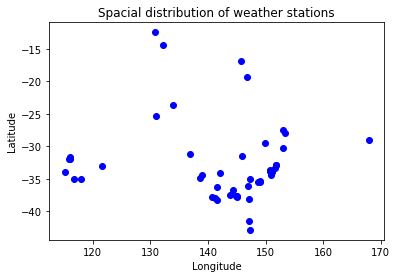

In [18]:
weather_loc_indices = location_coord_df['Location'].isin(weather_locations_s)
weather_locations = location_coord_df[weather_loc_indices]
plt.plot(weather_locations['lng'], weather_locations['lat'], 'bo')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spacial distribution of weather stations')
pass

### On Missing Values
We will handle missing values in our "Preparation of Data for Machine Learning" section. However, we must examine the distribution of missing values a little before we split our data into a test set and training set, as otherwise we run the risk of ending up with a test set that contains almost no "complete" observations, which would detract from the validity of our generalisation error estimate.

Therefore, let us examine the percentage of missing values for each feature and how these missing values depend upon location:

In [19]:
no_missing_values = aus_weather_df.isnull().sum(axis = 0) # Create series encoding number of missing values for each column
no_missing_values.sort_values(ascending = False)/len(aus_weather_df)

Sunshine         0.480098
Evaporation      0.431665
Cloud3pm         0.408071
Cloud9am         0.384216
Pressure9am      0.103568
Pressure3pm      0.103314
WindDir9am       0.072639
WindGustDir      0.070989
WindGustSpeed    0.070555
Humidity3pm      0.030984
WindDir3pm       0.029066
Temp3pm          0.024811
RainTomorrow     0.022460
RainToday        0.022419
Rainfall         0.022419
WindSpeed3pm     0.021050
Humidity9am      0.018246
Temp9am          0.012148
WindSpeed9am     0.012148
MinTemp          0.010209
MaxTemp          0.008669
lat              0.000000
Date             0.000000
Location         0.000000
lng              0.000000
dtype: float64

We see that the features Sunshine, Evaporation, Cloud3pm, and Cloud9am all have at least 38% missing values. 

Now let us look at how missing values depend upon location:

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,lat,lng
Location,,,,,,,,,,,,,,,,,,,,,
Adelaide,0,2,3,102,1489,1424,26,26,274,16,...,8,7,3193,3193,5,4,102,103,0,0
Albany,0,63,54,24,290,520,3040,3040,247,783,...,25,25,38,711,39,712,24,24,0,0
Albury,0,11,11,29,3040,3040,32,32,525,46,...,5,8,1751,1613,9,8,29,29,0,0
AliceSprings,0,1,2,8,215,520,51,51,230,4,...,1,3,334,361,0,2,8,9,0,0
BadgerysCreek,0,36,29,81,3009,3009,76,76,435,85,...,168,173,3009,3009,41,44,81,81,0,0


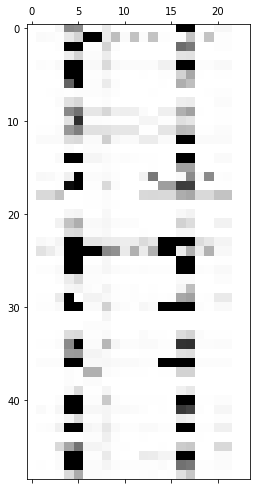

In [20]:
location_index = aus_weather_df['Location']
aus_weather_df[location_index == 'Canberra']
a = aus_weather_df.isnull()
a['Location'] = aus_weather_df['Location']
plt.matshow((a.groupby('Location').sum())/(a.groupby('Location').count()), cmap = 'binary')
((a.groupby('Location').sum())).head()

We see that the majority of missing values occur for particular features in specific locations. Since we will use stratified sampling based upon location, the proportion of missing values in our train and test set should be similar.

We should also discard any observations for which no observation exists for "RainTomorrow":

In [21]:
aus_weather_df.dropna(subset = ['RainTomorrow'], inplace = True)
aus_weather_df.reset_index(drop = True, inplace = True)

### Encoding Binary Variables as 0 and 1
The RainTomorrow and RainToday columns are currently in string format and contain either "Yes", "No", or are missing a value. Only around 2% of values are missing however, and we will discuss imputing values in or Preprocessing section.

In [22]:
print(aus_weather_df['RainToday'].value_counts())
print(aus_weather_df['RainTomorrow'].value_counts())

No     109332
Yes     31455
Name: RainToday, dtype: int64
No     110316
Yes     31877
Name: RainTomorrow, dtype: int64


In [23]:
def binary_encoder(x):
    if (x == 'Yes') or (x == 1):
        return 1
    elif (x == 'No') or (x == 0):
        return 0
    else:
        return x

aus_weather_df['RainToday'] = aus_weather_df['RainToday'].apply(binary_encoder)
aus_weather_df['RainTomorrow'] = aus_weather_df['RainTomorrow'].apply(binary_encoder)
aus_weather_df[:][:20]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,lat,lng
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0,-36.0806,146.9158
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0,-36.0806,146.9158
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0,-36.0806,146.9158
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0,-36.0806,146.9158
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0,-36.0806,146.9158
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,1009.2,1005.4,NaN,NaN,20.6,28.9,0.0,0,-36.0806,146.9158
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,1009.6,1008.2,1.0,NaN,18.1,24.6,0.0,0,-36.0806,146.9158
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,1013.4,1010.1,NaN,NaN,16.3,25.5,0.0,0,-36.0806,146.9158
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,1008.9,1003.6,NaN,NaN,18.3,30.2,0.0,1,-36.0806,146.9158
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,1007.0,1005.7,NaN,NaN,20.1,28.2,1.0,0,-36.0806,146.9158


### Encoding Cyclical Data
#### Dates:

In [24]:
def date_to_cyclic(Series):
    dates = pd.to_datetime(Series)
    days_of_year = dates.apply(lambda date : date.day_of_year) #The day in the year for each date ("Jan 1" = 1 etc.)
    years = dates.apply(lambda date : date.year) #The year for each date
    is_leap_year = dates.apply(lambda date : date.is_leap_year) #Binary variable indicating if a date belongs to a leap year
    
    days_of_year[is_leap_year == 1] = days_of_year[is_leap_year == 1]/366 #Re-encode as fractions of the total days in a year
    days_of_year[is_leap_year == 0] = days_of_year[is_leap_year == 0]/365 #Re-encode as fractions of the total days in a year
    dates_x = np.cos(2*np.pi*days_of_year)
    dates_y = np.sin(2*np.pi*days_of_year)
    cyclic_dates = pd.concat([dates_x, dates_y, years], axis = 1) #Concatenate into a single pandas dataframe
    cyclic_dates.columns = ['dates_x', 'dates_y', 'Year'] #Assign meaningful column names
    return cyclic_dates

cyclic_dates = date_to_cyclic(aus_weather_df['Date'])
aus_weather_df = aus_weather_df.join(cyclic_dates)

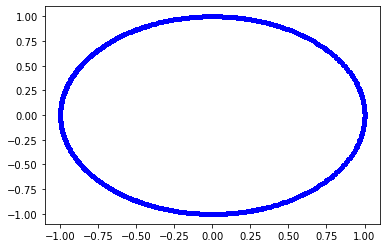

In [25]:
plt.plot(aus_weather_df['dates_x'], aus_weather_df['dates_y'], 'b.')
pass

#### Wind Directions:

With wind directions, as there are missing values, we must convert them to numeric values in a single column to allow for our imputation step which will take the median of each column (as otherwise the resulting directoin vector may not be the median vector). Then we will convert this numeric column to two columns that will together encode direction in the cartesian real plane.

In [26]:
aus_weather_df['WindGustDir'].unique()

def direction_to_num(x):
    direction_to_fraction = {'N' : 4/16, 'NNE' : 3/16, 'NE' : 2/16, 'ENE' : 1/16,
    'E' : 0, 'ESE' : 15/16, 'SE' : 14/16, 'SSE' : 13/16,
    'S' : 12/16, 'SSW' : 11/16, 'SW' : 10/16, 'WSW' : 9/16,
    'W' : 8/16, 'WNW' : 7/16, 'NW' : 6/16, 'NNW' : 5/16}
    if x in direction_to_fraction:
        return direction_to_fraction[x]
    else:
        return x
def direction_to_fraction(Series):
    numeric_direction = Series.apply(direction_to_num)
    numeric_direction.name = Series.name + '_frac'
    return numeric_direction
    
def direction_to_cyclic(Series):
    numeric_direction = Series.apply(direction_to_num)
    direction_x = np.cos(2*np.pi*numeric_direction)
    direction_y = np.sin(2*np.pi*numeric_direction)
    direction_x.name = Series.name +'_x'
    direction_y.name = Series.name +'_y'
    directions = pd.concat([direction_x, direction_y], axis = 1)
    return directions

weather_frac = {}
directions = {}

for name in ('WindDir9am', 'WindDir3pm', 'WindGustDir'):
    weather_frac[name] = direction_to_fraction(aus_weather_df[name])
    directions[name] = direction_to_cyclic(aus_weather_df[name])

wind_directions_pd = pd.concat([directions['WindDir9am'],
                                directions['WindDir3pm'],
                                directions['WindGustDir'],
                                weather_frac['WindDir9am'],
                                weather_frac['WindDir3pm'],
                                weather_frac['WindGustDir']], axis = 1)
wind_fractions_pd = pd.concat([weather_frac['WindDir9am'],
                                weather_frac['WindDir3pm'],
                                weather_frac['WindGustDir']], axis = 1)
wind_fractions_pd.isnull().sum()

WindDir9am_frac     10013
WindDir3pm_frac      3778
WindGustDir_frac     9330
dtype: int64

In [27]:
weather_with_wind_frac = aus_weather_df.join(wind_fractions_pd)
weather_with_wind_frac.drop(['WindDir9am', 'WindDir3pm', 'WindGustDir'], axis = 1, inplace = True)

In [28]:
weather_with_wind_frac

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,RainToday,RainTomorrow,lat,lng,dates_x,dates_y,Year,WindDir9am_frac,WindDir3pm_frac,WindGustDir_frac
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,0.0,0,-36.0806,146.9158,0.870285,-0.492548,2008,0.5000,0.4375,0.5000
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,0.0,0,-36.0806,146.9158,0.878612,-0.477536,2008,0.3125,0.5625,0.4375
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,0.0,0,-36.0806,146.9158,0.886680,-0.462383,2008,0.5000,0.5625,0.5625
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,0.0,0,-36.0806,146.9158,0.894487,-0.447094,2008,0.8750,0.0000,0.1250
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,0.0,0,-36.0806,146.9158,0.902030,-0.431673,2008,0.0625,0.3750,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,31.0,15.0,13.0,...,0.0,0,-25.3444,131.0369,-0.980469,0.196673,2017,0.9375,0.0000,0.0000
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,31.0,13.0,11.0,...,0.0,0,-25.3444,131.0369,-0.983709,0.179767,2017,0.8750,0.0625,0.0000
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,22.0,13.0,9.0,...,0.0,0,-25.3444,131.0369,-0.986658,0.162807,2017,0.8750,0.2500,0.3125
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,37.0,9.0,9.0,...,0.0,0,-25.3444,131.0369,-0.989314,0.145799,2017,0.8750,0.4375,0.2500


### Train Test Split
We are now ready to split our data into a training set and a test set. We will use stratified sampling to preserve the proportions of locations in the training data.

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)
for train_index, test_index in split.split(weather_with_wind_frac, weather_with_wind_frac['Location']):
    train_set = weather_with_wind_frac.loc[train_index]
    test_set = weather_with_wind_frac.loc[test_index]

## Explore the Data
We now perform some exploratory data analysis on the training set.

In [30]:
weather = train_set.copy()
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,RainToday,RainTomorrow,lat,lng,dates_x,dates_y,Year,WindDir9am_frac,WindDir3pm_frac,WindGustDir_frac
124364,2010-06-25,Walpole,4.6,14.7,2.0,NaN,NaN,37.0,13.0,17.0,...,1.0,0,-34.9777,116.7338,-0.993747,0.111659,2010,0.4375,0.3750,0.3750
23029,2015-11-07,NorfolkIsland,12.8,20.4,0.0,4.4,10.1,28.0,13.0,15.0,...,0.0,0,-29.0408,167.9547,0.598181,-0.801361,2015,0.1250,0.5000,0.5000
21086,2010-04-14,NorfolkIsland,20.3,23.3,1.4,2.0,1.2,31.0,20.0,15.0,...,1.0,0,-29.0408,167.9547,-0.217723,0.976011,2010,0.8125,0.8750,0.8125
116328,2013-09-16,PerthAirport,5.9,21.8,0.0,1.6,7.0,81.0,24.0,43.0,...,0.0,1,-31.9385,115.9672,-0.251190,-0.967938,2013,0.2500,0.3125,0.3125
67621,2014-07-22,Melbourne,5.6,12.5,0.0,0.4,3.0,17.0,9.0,9.0,...,0.0,0,-37.8136,144.9631,-0.938377,-0.345612,2014,0.2500,0.3125,0.1875


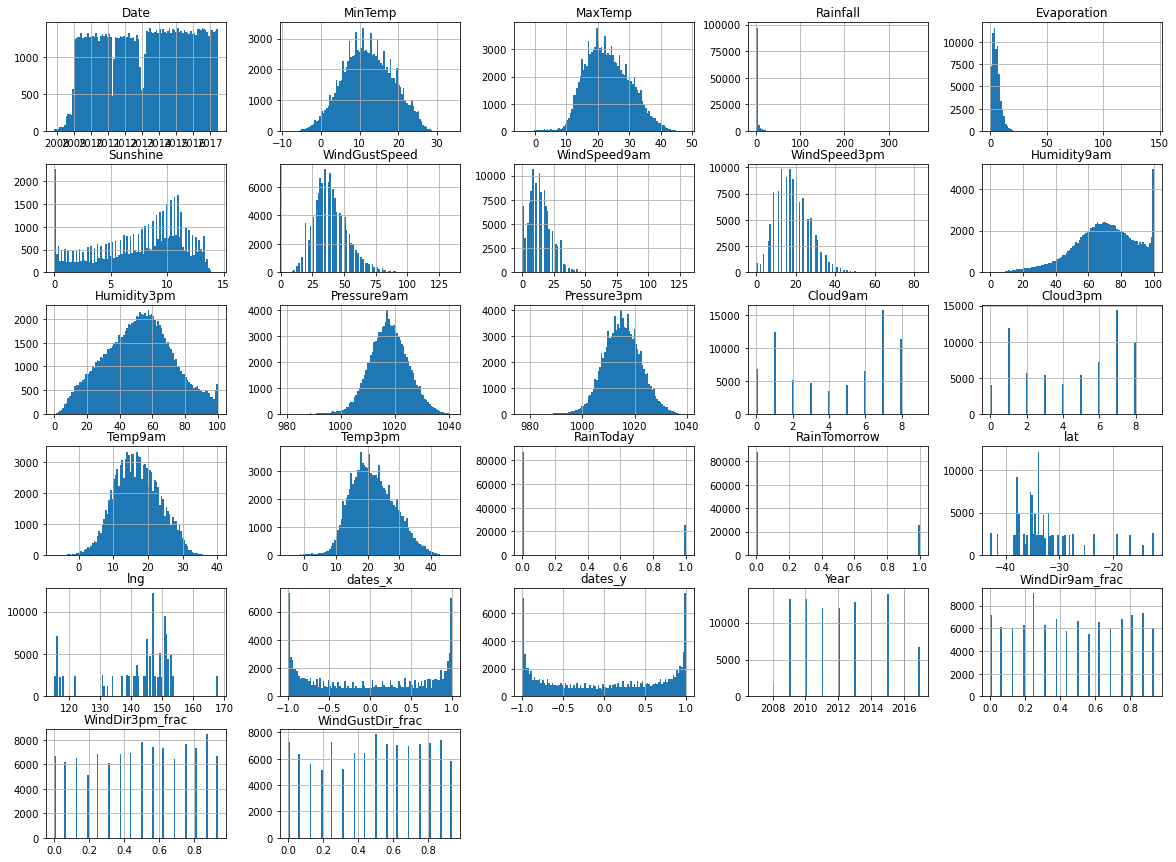

In [31]:
weather.hist(bins = 100, figsize = (20, 15))
pass

We see that Humidity9am and Humidity3pm appear to be capped at 100. Humidity of 100 means that the air is saturated with water vapour and has reached its "dew point" (https://en.wikipedia.org/wiki/Humidity) (I am infering that these humidty readings are for "relative humidity", since they are given on a percent scale) . Therefore this is a natural maximum, and not a result of instrumental limitations (although it is a limitation of relative humidity as a metric to record all information, absolute humidity may have been more predictively useful).

We have many zero values for Rainfall, Evaporation, and Sunshine. In all of these cases it might be valuable to add an additional binary variable to indicate if an observation is at the maximum/minimum.

We can compare the number of observations for each location:

In [32]:
weather['Location'].value_counts()

Canberra            2734
Sydney              2670
Darwin              2554
Perth               2554
Hobart              2550
Brisbane            2529
Adelaide            2472
Bendigo             2427
Townsville          2426
AliceSprings        2425
MountGambier        2424
Ballarat            2422
Launceston          2422
Albany              2413
Albury              2409
MelbourneAirport    2407
PerthAirport        2407
Mildura             2406
SydneyAirport       2404
Nuriootpa           2402
Sale                2400
Watsonia            2399
Tuggeranong         2398
Portland            2397
Woomera             2392
Cobar               2390
Cairns              2390
Wollongong          2386
GoldCoast           2384
WaggaWagga          2381
NorfolkIsland       2371
Penrith             2371
Newcastle           2364
SalmonGums          2364
Witchcliffe         2362
CoffsHarbour        2362
Richmond            2361
Dartmoor            2355
BadgerysCreek       2343
NorahHead           2343


We can visualise how the mean rainfall varies depending on latitude and longitude:

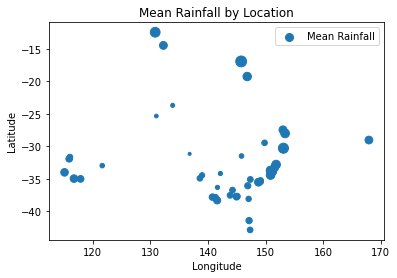

In [33]:
temp = weather.groupby(['lat', 'lng'], as_index = False).mean()
plt.scatter(x = temp['lng'],y = temp['lat'], s = 20*temp['Rainfall'], label = 'Mean Rainfall')
plt.legend()
plt.title('Mean Rainfall by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
pass

### Scatter Plots to discover "simple" relationships

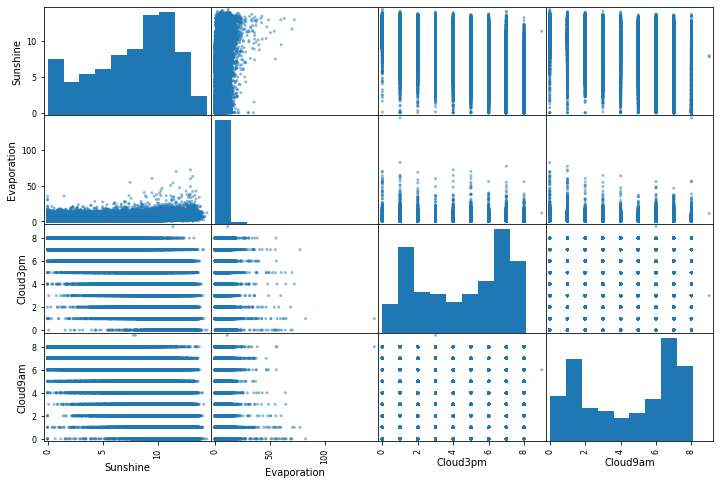

In [34]:
attributes = ['Sunshine' ,'Evaporation','Cloud3pm' ,'Cloud9am']
from pandas.plotting import scatter_matrix
scatter_matrix(weather[attributes], figsize = (12,8))
pass

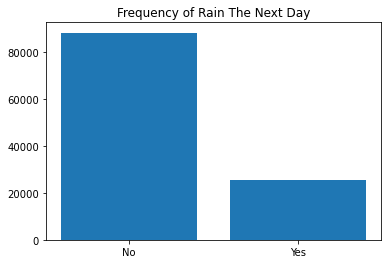

In [35]:
plt.bar(['No', 'Yes'], height = weather['RainTomorrow'].value_counts().values)
plt.title('Frequency of Rain The Next Day')
pass

## Prepare the Data

Before using this data in an ML model, we must endcode all of our attributes in effective formats. We must decide how we will handle missing values, and we must decide if there are any additional features that we wish to add that could be of benefit to the model. This whole process should be done in such a way that it can be automated, so that when new data becomes available we do not need to manually repeat all of these steps. We construct a simple data preprocess "pipeline" for this purpose.

Text(0.5, 1.0, 'Dates in Australian Weather Data')

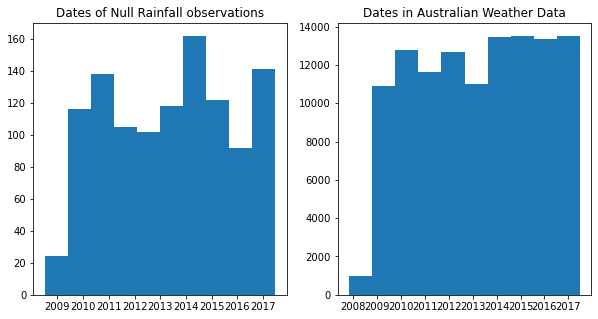

In [36]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
#onehot.fit_transform(weather[['RainToday', 'RainTomorrow']])
#weather[['Rainfall', 'RainToday', 'RainTomorrow']].isnull().sum()
(weather['Rainfall'].isnull()  & weather['RainToday'].isnull()).sum()
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(weather[(weather['Rainfall'].isnull()  & weather['RainToday'].isnull())]['Date'], bins = 10)
ax1.set_title('Dates of Null Rainfall observations')
ax2.hist(weather['Date'], bins = 10)
ax2.set_title('Dates in Australian Weather Data')

We see that missing values in "RainToday" correspond exactly to missing values in "Rainfall".
From the two histograms we see that the distribution of dates of null values for Rainfall is similar to the distribution of dates in the whole dataset.

We now drop "Date" from our data frame:

In [37]:
weather.drop(['Date'], axis = 1, inplace = True)

### Missing Values

Given that weather obviously is dependent upon, to some degree, many of the features in this dataset (and I would assume especially date and location, though ideally an expert would be consulted), a more intelligent interpolation would seem both possible and beneficial. Indeed, interpolating missing values for each feature could represent its own machine learning problem, where we build a predictive model for each feature based upon the other features available to us (excluding RainTomorrow), and validate and test the performance of these interpolating models in the same way that we would any machine learning model. We would split our current test set into further training and test sets for the purposes of training and testing these models to make predictions for all of the features with missing values in our test set. Then when we received new weather data, if there were missing values these models would be used to "predict" the values of the null values in our new data for the purposes of interpolation, allowing us to feed it into our final model that predicts if it will rain tomorrow. 

This clearly represents a significant amount of work, more in fact than the problem of finding a model to predict if it will rain tomorrow given clean data. We will at least examine some strategies, but the lack of suitable functionality in Sklearn means that automating these processes would be challenging. Sklearn does for example have an experimental "IterativeImputer" (for considering multiple features) and a K-nearest neighbours imputer (https://scikit-learn.org/stable/modules/impute.html), but these rely upon features being in an "acceptable" format for machine learning algorithms in Sklearn. Unfortunately, feature scaling must take place after imputing or removing missing values, as must one-hot-encoding and so on. This is a problem as the measures of distance or loss used by these imputing algorithms will then be wildly skewed by the scales of the different features, discrediting results from such imputations. Tackling all of this would represent its own project, one that is indeed interesting, but which would stall this one, and so it is something I will return to at a later date.

One simple method for imputing values I have considered is, for a given instance on a given date (fortunately date is never missing in this dataset), to impute a missing value using the most recent observation at that location, and if there is no data available at said location, to impute the missing value using the most recent observation from the most geographically near location for which an observation exists. 

In [38]:
no_missing_values = aus_weather_df.isnull().sum(axis = 0) # Create series encoding number of missing values for each column
no_missing_values.sort_values(ascending = False)/len(aus_weather_df)

Sunshine         0.476929
Evaporation      0.427890
Cloud3pm         0.401525
Cloud9am         0.377353
Pressure9am      0.098556
Pressure3pm      0.098324
WindDir9am       0.070418
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir3pm       0.026570
Humidity3pm      0.025388
Temp3pm          0.019171
WindSpeed3pm     0.018496
Humidity9am      0.012476
RainToday        0.009888
Rainfall         0.009888
WindSpeed9am     0.009480
Temp9am          0.006358
MinTemp          0.004480
MaxTemp          0.002265
dates_y          0.000000
lng              0.000000
dates_x          0.000000
Date             0.000000
lat              0.000000
RainTomorrow     0.000000
Location         0.000000
Year             0.000000
dtype: float64

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,lat,lng,dates_x,dates_y,Year
Location,,,,,,,,,,,,,,,,,,,,,
Adelaide,0.0,0.000647,0.000647,0.022654,0.466343,0.450485,0.007443,0.007443,0.083819,0.004854,...,1.000000,0.001618,0.001294,0.022654,0.0,0.0,0.0,0.0,0.0,0.0
Albany,0.0,0.019562,0.010610,0.006631,0.092838,0.167772,1.000000,1.000000,0.080902,0.254310,...,0.230438,0.011936,0.230769,0.006631,0.0,0.0,0.0,0.0,0.0,0.0
Albury,0.0,0.001993,0.000332,0.006642,1.000000,1.000000,0.003321,0.003321,0.171704,0.013949,...,0.530056,0.001328,0.001328,0.006642,0.0,0.0,0.0,0.0,0.0,0.0
AliceSprings,0.0,0.000330,0.000330,0.001980,0.069614,0.168591,0.016496,0.016496,0.075883,0.001320,...,0.118113,0.000000,0.000660,0.001980,0.0,0.0,0.0,0.0,0.0,0.0
BadgerysCreek,0.0,0.004098,0.001025,0.017418,1.000000,1.000000,0.005464,0.005464,0.134904,0.020492,...,1.000000,0.005464,0.006831,0.017418,0.0,0.0,0.0,0.0,0.0,0.0
Ballarat,0.0,0.000330,0.000330,0.003633,1.000000,1.000000,0.007926,0.007926,0.030053,0.005284,...,0.343791,0.003963,0.001651,0.003633,0.0,0.0,0.0,0.0,0.0,0.0
Bendigo,0.0,0.000330,0.000330,0.001318,0.609426,1.000000,0.011866,0.011536,0.080092,0.013843,...,0.252802,0.000659,0.000330,0.001318,0.0,0.0,0.0,0.0,0.0,0.0
Brisbane,0.0,0.001898,0.001265,0.009174,0.006011,0.015185,0.004745,0.004745,0.021829,0.008542,...,0.000633,0.000633,0.002847,0.009174,0.0,0.0,0.0,0.0,0.0,0.0
Cairns,0.0,0.000335,0.000000,0.008032,0.114123,0.142570,0.006024,0.005689,0.014056,0.001339,...,0.068942,0.000000,0.000000,0.008032,0.0,0.0,0.0,0.0,0.0,0.0


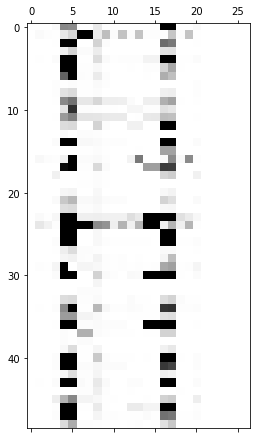

In [39]:
location_index = aus_weather_df['Location']
aus_weather_df[location_index == 'Canberra']
a = aus_weather_df.isnull()
a['Location'] = aus_weather_df['Location']
plt.matshow((a.groupby('Location').sum())/(a.groupby('Location').count()), cmap = 'binary')
((a.groupby('Location').sum())/(a.groupby('Location').count()))

We see from this that there are several locations for which no observations exist at all for the 4 variables Sunshine, Evaporation, Cloud3pm, and Cloud9am. Given this and the fact that these features each have at least 38% missing values we remove these 4 features. or could maybe interpolate again using locations? (or too little information to interpolate)    
We do have that WindGustDir 	WindGustSpeed have no observations for "Albany" and "Newcastle" - could interpolate using location (as have many more observations). There are also several locations with no observations for Pressure9am and Pressure3pm.

In [40]:
col_names = weather.columns.values #numpy array of column names
missing_values = pd.DataFrame()
for col_name in col_names:
    no_null = weather[col_name].isnull().sum() #Number of missing values for named column in aus_weather_df
    missing_values[col_name] = pd.Series(no_null)
missing_values

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,RainToday,RainTomorrow,lat,lng,dates_x,dates_y,Year,WindDir9am_frac,WindDir3pm_frac,WindGustDir_frac
0,0,521,250,1120,48701,54293,7468,1103,2142,1399,...,1120,0,0,0,0,0,0,8023,3064,7511


#### A very naive imputation:
We can very naively interpolate all missing values as the meadian of their respective columns. This will obviously be sub-optimal but it will allow us to at least keep all of our original data (hopefully without drowning it out).

We want to impute values before making transformations in some cases, at least when using this simple imputer. In particular we use the simple imputer on the three wind direction columns encoded as fractions, and then transform these complete columns to two columns each which together encode direction in the euclidean sense. This is because the simple imputer would not treat these pairs of coordinate columns as "pairs", rather imputing for each one seperately. This could lead to a different set of imputed values for this reason.

In [41]:
weather

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,RainToday,RainTomorrow,lat,lng,dates_x,dates_y,Year,WindDir9am_frac,WindDir3pm_frac,WindGustDir_frac
124364,Walpole,4.6,14.7,2.0,NaN,NaN,37.0,13.0,17.0,74.0,...,1.0,0,-34.9777,116.7338,-0.993747,0.111659,2010,0.4375,0.3750,0.3750
23029,NorfolkIsland,12.8,20.4,0.0,4.4,10.1,28.0,13.0,15.0,52.0,...,0.0,0,-29.0408,167.9547,0.598181,-0.801361,2015,0.1250,0.5000,0.5000
21086,NorfolkIsland,20.3,23.3,1.4,2.0,1.2,31.0,20.0,15.0,73.0,...,1.0,0,-29.0408,167.9547,-0.217723,0.976011,2010,0.8125,0.8750,0.8125
116328,PerthAirport,5.9,21.8,0.0,1.6,7.0,81.0,24.0,43.0,67.0,...,0.0,1,-31.9385,115.9672,-0.251190,-0.967938,2013,0.2500,0.3125,0.3125
67621,Melbourne,5.6,12.5,0.0,0.4,3.0,17.0,9.0,9.0,93.0,...,0.0,0,-37.8136,144.9631,-0.938377,-0.345612,2014,0.2500,0.3125,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99897,MountGambier,8.2,20.1,0.4,NaN,NaN,35.0,17.0,24.0,56.0,...,0.0,0,-37.8284,140.7804,-0.030120,0.999546,2017,0.8750,0.7500,0.9375
76320,Watsonia,7.5,11.8,2.8,0.2,0.0,13.0,9.0,0.0,100.0,...,1.0,0,-37.7080,145.0830,-0.932289,-0.361714,2010,0.6875,NaN,0.6250
109278,Witchcliffe,11.8,18.3,7.0,NaN,NaN,39.0,13.0,11.0,67.0,...,1.0,0,-34.0168,115.0973,0.467359,-0.884068,2009,0.5625,0.6250,0.5625
74712,Portland,4.0,13.4,0.0,0.2,9.4,24.0,9.0,15.0,93.0,...,0.0,0,-38.3333,141.6000,-0.720667,-0.693281,2014,0.3125,0.5000,0.5000


In [42]:
weather_frac_index = {}
for name in ('WindDir9am_frac','WindDir3pm_frac', 'WindGustDir_frac'):
    weather_frac_index[name] = weather.columns.get_loc(name)

weather.iloc[:, list(weather_frac_index.values())] #This line is to check if these indices are indeed correct

,WindDir9am_frac,WindDir3pm_frac,WindGustDir_frac
124364,0.4375,0.3750,0.3750
23029,0.1250,0.5000,0.5000
21086,0.8125,0.8750,0.8125
116328,0.2500,0.3125,0.3125
67621,0.2500,0.3125,0.1875
...,...,...,...
99897,0.8750,0.7500,0.9375
76320,0.6875,NaN,0.6250
109278,0.5625,0.6250,0.5625
74712,0.3125,0.5000,0.5000


In [62]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

weather_num = weather.drop(['Location', 'RainToday', 'RainTomorrow'], axis = 1)
num_attribs = list(weather_num)
cat_attribs = ['Location']
other_attribs = ['RainToday']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('std_scalar', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_attribs),
    ('num', num_pipeline, num_attribs),
    ('other', SimpleImputer(strategy = 'median'), other_attribs)],
    remainder='passthrough')
#We allow RainToday and RainTomorrow to pass through as we do not want to standardise them. 
#This is not infact used here as RainTomorrow is dropped first and we impute on RainToday

wind_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = "median")),
    ('std_scalar', StandardScaler())
])

y_train = weather['RainTomorrow']
y_train = np.array(y_train)
#y_train = y_train.reshape(-1, 1)

weather_x = weather.drop(['RainTomorrow'], axis = 1)
X_train = full_pipeline.fit_transform(weather_x)

In [63]:
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Train and Shortlist Models

We start with a simple logistic regressoin model. Logistic regression utilises a linear decision boundary which may  underfit our model.

In [65]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
y_train_pred = cross_val_predict(clf, X_train, y_train, cv = 3)

In [70]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
confusion_matrix(y_train, y_train_pred)

array([[83415,  4839],
       [12605, 12895]], dtype=int64)

In [75]:
print(precision_score(y_train, y_train_pred),'(= 12895/(12895 + 4839))')
print(recall_score(y_train, y_train_pred), '(=12895/(12895 + 12605))')

0.7271343182587121 (= 12895/(12895 + 4839))
0.505686274509804 (=12895/(12895 + 12605))
